In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm

import numpy as np
import copy
import json

USE_CUDA = True

In [2]:
def readfile(data):
    with open(data, "r", encoding="utf-8") as f:
        content = f.read().splitlines()
        
    return content

def schema_load(schema_root):
    raw_dict = "".join(readfile(schema_root))
    dict2json = "".join(raw_dict.split()[2:])

    json_acceptable_string = dict2json.replace("'", "\"")
    schema = json.loads(json_acceptable_string)
    
    return schema

def define_entity(schema):
    tag_type = list(schema['tagging'])
    
    entity_tag = []
    for k in list(schema['entity'].keys()):
        entity_tag.append(schema['entity'][k]['tag'])
        
    TAG = []
    for t in tag_type:
        for e in entity_tag:
            if t!='O':
                TAG.append(t+'-'+e)  
                
    TAG = [UNKOWN_TAG, PAD_TAG] + TAG + ['O']   

    return TAG

def tag2ix(TAG):
    tag_to_ix={t:i for i,t in enumerate(TAG)}
    return tag_to_ix

def define_relation(schema):
    relation_type = list(schema['relation'])
    
    relation_tag = []
    for k in list(schema['relation'].keys()):
        relation_tag.append(schema['relation'][k]['tag'])
    
    relation_tag = [REL_PAD] + [REL_NONE] + relation_tag
        
    return relation_tag

# ==================================================

def get_word_and_label(_content, start_w, end_w):
    word_list = []
    ent_list = []
    rel_list = []
    
    for word_set in _content[start_w:end_w]:
        word_set = word_set.split()
        if len(word_set)==1:
            word_list.append(' ')
            ent_list.append('O')
            rel_list.append(REL_NONE)
        
        else:
            word_list.append(word_set[0])
            ent_list.append(word_set[1])

            try:
                testerror = word_set[2]
            except IndexError:
                rel_list.append(REL_NONE)
            else:
                rel_list.append(word_set[2:])
    
    return word_list, ent_list, rel_list

def split_to_list(content):
    init = 0
    word_list = []
    ent_list = []
    rel_list = []

    for now_token, c in enumerate(content):
        if c=='':
            words, ents, rels = get_word_and_label(content, init, now_token)
            init = now_token+1
            word_list.append(words)
            ent_list.append(ents)
            rel_list.append(rels)
            
    return word_list, ent_list, rel_list

# ==================================================

def word2index(word_list):
    word_to_ix = {"<UNKNOWN>":0, "<PAD>":1}
    for sentence in word_list:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
                
    return word_to_ix

def dict_inverse(tag_to_ix):
    ix_to_tag = {v: k for k, v in tag_to_ix.items()}
    return ix_to_tag

def index2tag(indexs, ix_to):
    to_tags = [ix_to[i] for i in indexs.cpu().numpy()]
    return to_tags

# ==================================================

def find_max_len(word_list):
    max_len = 0
    for i in range(len(word_list)):
        if max_len<len(word_list[i]):
            max_len=len(word_list[i])
            
    return max_len

# ====== filter the length of sentence more than MAX_LEN =======

def filter_len(word_list):
    reserved_index = []
    for i in range(len(word_list)):
        if len(word_list[i])<MAX_LEN:
            reserved_index.append(i)
            
    return reserved_index


def filter_sentence(reserved_index, word_list, ent_list, rel_list):
    filter_word = list(word_list[i] for i in reserved_index)
    filter_ent = list(ent_list[i] for i in reserved_index)
    filter_rel = list(rel_list[i] for i in reserved_index)
    return filter_word, filter_ent, filter_rel

# ==================================================

def pad_seq(seq, isrel):
    if isrel:
        seq += [REL_NONE for i in range(MAX_LEN-len(seq))]
    else:
        seq += [PAD_TAG for i in range(MAX_LEN-len(seq))]
    return seq

def pad_all(filter_word, filter_ent, filter_rel):
    input_padded = [pad_seq(s, False) for s in filter_word]
    ent_padded = [pad_seq(s, False) for s in filter_ent]
    rel_padded = [pad_seq(s, True) for s in filter_rel]
    
    return input_padded, ent_padded, rel_padded

def deep_copy_lists(filter_word, filter_ent, filter_rel):
    f_w = copy.deepcopy(filter_word)
    f_e = copy.deepcopy(filter_ent)
    f_r = copy.deepcopy(filter_rel)
    
    return f_w, f_e, f_r

# ==================================================

def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix[UNKOWN_TAG])
        else:
            idxs.append(to_ix[w])
    
#     idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_all(seqs, to_ix):
    seq_list = []
    for i in range(len(seqs)):
        seq_list.append(prepare_sequence(seqs[i], to_ix))
        
    seq_list = torch.stack(seq_list)
        
    return seq_list



def prepare_rel(rel_padded, to_ix):
    
    rel_ptr = torch.zeros(len(rel_padded), MAX_LEN, MAX_LEN, dtype=torch.long) 
    
    # 對當前的token，去比較之前所有出現過的entity，是否有關係，建成矩陣
    # [B*ML*ML]，第二維ML是當前token，第三維ML是根據當前token對之前出現過的entity紀錄關係，以index紀錄
    for i, rel_seq in enumerate(rel_padded):
        rel_dict = {}
        for j, token_seq in enumerate(rel_seq):
            rel_ptr[i][j][:j+1] = 1
            if token_seq != REL_NONE:
                for k, rel in enumerate(token_seq):

                    # if 是第一次出現，紀錄後面數字(標第幾對)和關係位置(A OR B)
                    # 假如下次出現又是同個關係位置(A)，依然紀錄
                    # 直到下次出現關係位置B，依照之前紀錄的A位置的字，然後在第三維去標關係

                    rel_token = rel.split('-')
                    if rel_token[1] not in rel_dict:
                        rel_dict[rel_token[1]] = {'rel':rel_token[0], 'loc':rel_token[2], 'idx':[j]}

                    elif rel_token[1] in rel_dict and rel_dict[rel_token[1]]['loc']==rel_token[2]:
                        rel_dict[rel_token[1]]['idx'].append(j)

                    else:
                        record_loc = rel_dict[rel_token[1]]['idx']
                        for idxx in record_loc:
                            rel_ptr[i][j][idxx] = to_ix[rel_token[0]]
                            
    return rel_ptr
                


# ==================================================

def dataload(input_var, ent_var, rel_var, raw_input):
    torch_dataset = Data.TensorDataset(input_var, ent_var, rel_var, raw_input)

    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               
        num_workers=2,       
#         drop_last=True
    )
    
    return loader

# ==================================================
def softmax_entity(entity):
    entity = entity.view(BATCH_SIZE,ent_size).argmax(1)
    return entity

In [3]:
class Attn(nn.Module):
    def __init__(self, attn_input, attn_output, rel_size):
        super(Attn, self).__init__()
        
        self.attn_input = attn_input
        self.attn_output = attn_output
        self.rel_size = rel_size
        
        self.w1 = nn.Linear(self.attn_input, self.attn_output)
        self.w2 = nn.Linear(self.attn_input, self.attn_output)
        self.tanh = nn.Tanh()
        self.v = nn.Linear(self.attn_output, self.rel_size, bias=False)
        self.softmax = nn.LogSoftmax(dim=2)
        
        
    def forward(self, encoder_outputs):
        
        decoder = encoder_outputs[:,-1,:].unsqueeze(1)                       #B*1*(ts+LE) [128,1,8]
        encoder_score = self.w1(encoder_outputs)                             #B*now len*ATTN_OUT
        decoder_score = self.w2(decoder)                                     #B*1*ATTN_OUT
        energy = self.tanh(encoder_score+decoder_score)                      #B*now len*ATTN_OUT            
        
        energy = self.v(energy)                                              #B*now len*rel_size
        
        
        # 針對每個entity做softmax，去顯示他們的關係權重
        # 主要都會是rel_none
        # 對第二維(rel)做softmax
        p = self.softmax(energy)                                         #B*now len*rel_size
        
        return p
    

In [4]:
class Entity_Typing(nn.Module):
    def __init__(self, vocab_size, ent_tag_to_ix, embedding_dim, hidden_dim1, hidden_dim2, \
                 label_embed_dim, rel_tag_to_ix):
        
        super(Entity_Typing, self).__init__()
        self.embedding_dim = embedding_dim                   #E
        self.hidden_dim1 = hidden_dim1                       #h1
        self.hidden_dim2 = hidden_dim2                       #h2
        self.label_embed_dim = label_embed_dim               #LE
        self.vocab_size = vocab_size                         #vs
        self.ent_to_ix = ent_tag_to_ix
        self.ent_size = len(ent_tag_to_ix)                   #es
        self.rel_to_ix = rel_tag_to_ix
        self.rel_size = len(rel_tag_to_ix)                   #rs           
        
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(DENSE_OUT, momentum=0.5, affine=False)
        
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
#         self.bilstm = nn.LSTM(embedding_dim, hidden_dim1 // 2,
#                             num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)        
        self.bilstm = nn.GRU(embedding_dim, hidden_dim1 // 2,
                            num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        
        
        self.dense = nn.Linear(hidden_dim1, DENSE_OUT)
        self.top_hidden = nn.LSTMCell(DENSE_OUT+label_embed_dim, hidden_dim2)          
        

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim2, self.ent_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.label_embed = nn.Linear(self.ent_size, self.label_embed_dim)
        
        self.attn = Attn(ATTN_IN, ATTN_OUT, self.rel_size)
        
        
    def init_hidden1(self):       
        hidden = torch.randn(2*2, self.batch, self.hidden_dim1 // 2)    #4*B*(h1/2)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_hidden2(self):       
        hidden = torch.randn(self.batch, self.hidden_dim2)              #B*h2

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_label_embed(self):
        hidden = torch.zeros(self.batch, self.label_embed_dim)          #B*LE
        return hidden.cuda()if USE_CUDA else hidden
    
    def create_entity(self):
        output_tensor = torch.zeros(self.batch, MAX_LEN, self.ent_size)  #B*ML*es
        return output_tensor.cuda()if USE_CUDA else output_tensor
    
    def create_rel_matrix(self):
        rel_tensor = torch.zeros(self.batch, MAX_LEN, MAX_LEN, self.rel_size)  #B*ML*ML*rs
        return rel_tensor.cuda()if USE_CUDA else rel_tensor
    
    
        
    def forward(self, sentence):
        
        self.batch = sentence.size(0)
#         self.hidden1 = self.init_hidden1()                      #4*B*(h1/2)
        entity_tensor = self.create_entity()                    #B*ML*es
        rel_tensor = self.create_rel_matrix()                   #B*ML*ML*rs
        
        

        embeds = self.word_embeds(sentence)                     #B*ML*E,[128, 100, 20]
        
#         bilstm_out, self.hidden1 = self.bilstm(embeds, self.hidden1)
        bilstm_out, hidden1 = self.bilstm(embeds)
        # bilstm_out -> B*ML*h1,[128, 100, 10]
        # self.hidden1 -> ( 4*B*(h1/2), 4*B*(h1/2) )
        
        # bn
        bilstm_out = self.bn(bilstm_out)
        dense_out = self.dense(bilstm_out)                      #B*ML*DENSE_OUT,[128, 100, 100]
        
        
        encoder_sequence_l = [] 

        for length in range(MAX_LEN):
            now_token = dense_out[:,length,:]
            now_token = torch.squeeze(now_token, 1)
            if length==0:
                
#                 fake_hidden=(100)
#                 noise_x = random(100)
                self.hidden2 = self.init_hidden2()
                self.zero_label_embed = self.init_label_embed()
                combine_x = torch.cat((now_token, self.zero_label_embed),1)  #B*(DENSE_OUT+LE),[128, 103]
                
            else:
#                 fake_hidden=h
                self.hidden2 = (h_next, c_next)
                combine_x = torch.cat((now_token, label),1)

            h_next, c_next = self.top_hidden(combine_x, self.hidden2)    #B*h2,[128, 8]           
            to_tags = self.hidden2tag(h_next)                            #B*es,[128, 5]            
            ent_output = self.softmax(to_tags)                               #B*es,[128, 5]             
            label = self.label_embed(ent_output)                             #B*LE,[128, 3]
            
            s_ent_output = self.softmax_entity(ent_output)
            
            
            # Assignments to Variables are in-place operations.
            # Use that variable in lots of other contexts 
            # and some of the functions require it to not change. 
            to_tags_clone = to_tags.clone()
            label_clone = label.clone()
            
            
#             for i, tag in enumerate(s_ent_output):
#                 if tag==ent_tag_to_ix['O']:
#                     to_tags_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
#                     label_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
                    
            # relation layer
#             encoder_sequence_l.append(torch.cat((to_tags,label),1)) 
            encoder_sequence_l.append(torch.cat((h_next,label),1))  
            encoder_sequence = torch.stack(encoder_sequence_l).t()     #B*len*(es+LE), [128,1,8]          

            # Calculate attention weights 
            attn_weights = self.attn(encoder_sequence)

        
            entity_tensor[:,length,:] = ent_output
            
            # rel_tensor[:,length, 頭~當前 ,:]
            rel_tensor[:,length,:length+1,:] = attn_weights

        
        
        '''NLLLoss input: Input: (N,C) where C = number of classes'''
        return entity_tensor.view(self.batch*MAX_LEN, self.ent_size), \
               rel_tensor.view(self.batch*MAX_LEN*MAX_LEN, self.rel_size)
        
        
    def softmax_entity(self, entity):
        entity = entity.view(self.batch,ent_size).argmax(1)
        return entity

In [5]:
root = '/notebooks/sinica/dataset/'
train_data = root+'facial.train'
dev_data = root+'facial.dev'
test_data = root+'facial.test'

relation_data_old = root+'facial_r.old.train'
# relation_data = root+'facial_r.train'
relation_data = root+'facial_r2.train'
schema_root = root+'schema.txt'
dev_data = root+'facial_r2.dev'
test_data = root+'facial_r2.test'


UNKOWN_TAG = "<UNKNOWN>"
PAD_TAG = "<PAD>"
REL_NONE = 'Rel-None'
REL_PAD = 'Rel-Pad'
rule = ('FUNC', 'ApplyTo', 'STAT')

schema = schema_load(schema_root)
ENT_TAG = define_entity(schema)
REL_TAG = define_relation(schema)
ent_tag_to_ix = tag2ix(ENT_TAG)
'''{'<PAD>': 1,
 '<UNKNOWN>': 0,
 'B-FUNC': 2,
 'B-STAT': 3,
 'I-FUNC': 4,
 'I-STAT': 5,
 'O': 6}'''
rel_tag_to_ix = tag2ix(REL_TAG)
'''{'ApplyTo': 2, 'Rel-None': 1, 'Rel-Pad': 0}'''

# ========hyper-parameter-set==========

ent_size = len(ent_tag_to_ix)
rel_size = len(rel_tag_to_ix)
MAX_LEN = 100
BATCH_SIZE = 18

EMBEDDING_DIM = 20
HIDDEN_DIM1 = 10
HIDDEN_DIM2 = 8
LABEL_EMBED_DIM = ent_size
DENSE_OUT = 100

# ATTN_IN = ent_size+LABEL_EMBED_DIM
ATTN_IN = HIDDEN_DIM2+LABEL_EMBED_DIM
ATTN_OUT = 6

In [6]:
def preprocess(data):
    content = readfile(data)
    word_list, ent_list, rel_list = split_to_list(content)
    word_to_ix = word2index(word_list)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    #================================================
    vocab_size = len(word_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, vocab_size, word_to_ix, reserved_index, word_list

def dev_preprocess(dev_data):
    dev_content = readfile(dev_data)
    word_list, ent_list, rel_list = split_to_list(dev_content)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, reserved_index, word_list


In [7]:
ix_to_ent_tag = dict_inverse(ent_tag_to_ix)
ix_to_rel_tag = dict_inverse(rel_tag_to_ix)
#===============================================
input_var, ent_var, rel_var, vocab_size, word_to_ix, raw_index, raw_input = preprocess(relation_data)
loader = dataload(input_var, ent_var, rel_var, raw_index)

input_dev, ent_dev, rel_dev, raw_index_dev, raw_input_dev = dev_preprocess(dev_data)
dev_loader = dataload(input_dev, ent_dev, rel_dev, raw_index_dev)

In [8]:
model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion_tag = nn.NLLLoss()
criterion_rel = nn.NLLLoss()

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
n_iters = 70
print_every = 12
all_ent_loss = []
all_rel_loss = []
total_loss = 0 # Reset every plot_every iters
loss = 0
ent_loss = 0

start = time.time()

for epoch in tqdm(range(n_iters)):  
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
        model.train()
        optimizer.zero_grad()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        batchsize = batch_x.size(0)
        
        batch_ent = batch_ent.view(batchsize*MAX_LEN)
        batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)
        
        loss_ent = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
        loss_rel = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
        loss = loss_ent+loss_rel
        
        loss.backward()
#         loss.backward(retain_graph=True)
        optimizer.step()
        
        if step % print_every == 1:
            all_ent_loss.append(loss_ent.cpu())
            all_rel_loss.append(loss_rel.cpu())
        #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))
        
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        batchsize = batch_x.size(0)
        
        val_loss_ent = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
        val_loss_rel = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
    
    
    print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
          % (epoch, loss_ent, loss_rel, loss))
    print("      %s  | val ent loss %.4f | val rel loss %.4f"
          % (" "*len(str(epoch)), val_loss_ent, val_loss_rel))


  1%|▏         | 1/70 [00:07<08:13,  7.16s/it]

epoch: 0 | ent loss 0.5869 | rel loss 0.0752 | total loss 0.6621
         | val ent loss 0.5324 | val rel loss 0.0683


  3%|▎         | 2/70 [00:14<07:56,  7.01s/it]

epoch: 1 | ent loss 0.3551 | rel loss 0.0254 | total loss 0.3805
         | val ent loss 0.3127 | val rel loss 0.0243


  4%|▍         | 3/70 [00:21<07:51,  7.04s/it]

epoch: 2 | ent loss 0.2916 | rel loss 0.0151 | total loss 0.3066
         | val ent loss 0.2461 | val rel loss 0.0134


  6%|▌         | 4/70 [00:28<07:50,  7.12s/it]

epoch: 3 | ent loss 0.2900 | rel loss 0.0120 | total loss 0.3020
         | val ent loss 0.2468 | val rel loss 0.0097


  7%|▋         | 5/70 [00:36<07:53,  7.29s/it]

epoch: 4 | ent loss 0.2666 | rel loss 0.0092 | total loss 0.2758
         | val ent loss 0.2209 | val rel loss 0.0077


  9%|▊         | 6/70 [00:44<07:50,  7.34s/it]

epoch: 5 | ent loss 0.2237 | rel loss 0.0085 | total loss 0.2322
         | val ent loss 0.1750 | val rel loss 0.0066


 10%|█         | 7/70 [00:51<07:45,  7.39s/it]

epoch: 6 | ent loss 0.1728 | rel loss 0.0078 | total loss 0.1806
         | val ent loss 0.1617 | val rel loss 0.0049


 11%|█▏        | 8/70 [00:59<07:42,  7.47s/it]

epoch: 7 | ent loss 0.1487 | rel loss 0.0067 | total loss 0.1553
         | val ent loss 0.1369 | val rel loss 0.0067


 13%|█▎        | 9/70 [01:07<07:40,  7.54s/it]

epoch: 8 | ent loss 0.1261 | rel loss 0.0062 | total loss 0.1323
         | val ent loss 0.1238 | val rel loss 0.0052


 14%|█▍        | 10/70 [01:16<07:37,  7.62s/it]

epoch: 9 | ent loss 0.1375 | rel loss 0.0057 | total loss 0.1432
         | val ent loss 0.1332 | val rel loss 0.0055


 16%|█▌        | 11/70 [01:24<07:30,  7.64s/it]

epoch: 10 | ent loss 0.1235 | rel loss 0.0050 | total loss 0.1285
          | val ent loss 0.1146 | val rel loss 0.0044


 17%|█▋        | 12/70 [01:31<07:23,  7.64s/it]

epoch: 11 | ent loss 0.1157 | rel loss 0.0051 | total loss 0.1208
          | val ent loss 0.1105 | val rel loss 0.0048


 19%|█▊        | 13/70 [01:39<07:15,  7.63s/it]

epoch: 12 | ent loss 0.1040 | rel loss 0.0039 | total loss 0.1079
          | val ent loss 0.1167 | val rel loss 0.0036


 20%|██        | 14/70 [01:46<07:06,  7.62s/it]

epoch: 13 | ent loss 0.0813 | rel loss 0.0037 | total loss 0.0850
          | val ent loss 0.1090 | val rel loss 0.0038


 21%|██▏       | 15/70 [01:54<06:58,  7.61s/it]

epoch: 14 | ent loss 0.0790 | rel loss 0.0037 | total loss 0.0827
          | val ent loss 0.0973 | val rel loss 0.0031


 23%|██▎       | 16/70 [02:02<06:53,  7.65s/it]

epoch: 15 | ent loss 0.0822 | rel loss 0.0039 | total loss 0.0860
          | val ent loss 0.0816 | val rel loss 0.0028


 24%|██▍       | 17/70 [02:09<06:45,  7.65s/it]

epoch: 16 | ent loss 0.0662 | rel loss 0.0041 | total loss 0.0703
          | val ent loss 0.0762 | val rel loss 0.0025


 26%|██▌       | 18/70 [02:17<06:37,  7.65s/it]

epoch: 17 | ent loss 0.0613 | rel loss 0.0039 | total loss 0.0652
          | val ent loss 0.0907 | val rel loss 0.0025


 27%|██▋       | 19/70 [02:25<06:29,  7.64s/it]

epoch: 18 | ent loss 0.0603 | rel loss 0.0032 | total loss 0.0634
          | val ent loss 0.0963 | val rel loss 0.0025


 29%|██▊       | 20/70 [02:32<06:22,  7.65s/it]

epoch: 19 | ent loss 0.0507 | rel loss 0.0024 | total loss 0.0531
          | val ent loss 0.0778 | val rel loss 0.0023


 30%|███       | 21/70 [02:40<06:14,  7.65s/it]

epoch: 20 | ent loss 0.0562 | rel loss 0.0030 | total loss 0.0592
          | val ent loss 0.1002 | val rel loss 0.0028


 31%|███▏      | 22/70 [02:48<06:07,  7.65s/it]

epoch: 21 | ent loss 0.0351 | rel loss 0.0023 | total loss 0.0374
          | val ent loss 0.0732 | val rel loss 0.0013


 33%|███▎      | 23/70 [02:55<05:59,  7.65s/it]

epoch: 22 | ent loss 0.0371 | rel loss 0.0029 | total loss 0.0401
          | val ent loss 0.0639 | val rel loss 0.0021


 34%|███▍      | 24/70 [03:03<05:51,  7.65s/it]

epoch: 23 | ent loss 0.0408 | rel loss 0.0024 | total loss 0.0433
          | val ent loss 0.0617 | val rel loss 0.0025


 36%|███▌      | 25/70 [03:11<05:44,  7.65s/it]

epoch: 24 | ent loss 0.0408 | rel loss 0.0030 | total loss 0.0438
          | val ent loss 0.0595 | val rel loss 0.0022


 37%|███▋      | 26/70 [03:19<05:36,  7.66s/it]

epoch: 25 | ent loss 0.0354 | rel loss 0.0025 | total loss 0.0378
          | val ent loss 0.0805 | val rel loss 0.0024


 39%|███▊      | 27/70 [03:26<05:29,  7.66s/it]

epoch: 26 | ent loss 0.0279 | rel loss 0.0018 | total loss 0.0297
          | val ent loss 0.0377 | val rel loss 0.0018


 40%|████      | 28/70 [03:34<05:21,  7.66s/it]

epoch: 27 | ent loss 0.0258 | rel loss 0.0026 | total loss 0.0284
          | val ent loss 0.0857 | val rel loss 0.0017


 41%|████▏     | 29/70 [03:42<05:14,  7.66s/it]

epoch: 28 | ent loss 0.0258 | rel loss 0.0020 | total loss 0.0278
          | val ent loss 0.0695 | val rel loss 0.0015


 43%|████▎     | 30/70 [03:49<05:06,  7.67s/it]

epoch: 29 | ent loss 0.0285 | rel loss 0.0023 | total loss 0.0309
          | val ent loss 0.0722 | val rel loss 0.0012


 44%|████▍     | 31/70 [03:57<04:59,  7.67s/it]

epoch: 30 | ent loss 0.0277 | rel loss 0.0019 | total loss 0.0297
          | val ent loss 0.0606 | val rel loss 0.0021


 46%|████▌     | 32/70 [04:05<04:51,  7.67s/it]

epoch: 31 | ent loss 0.0316 | rel loss 0.0022 | total loss 0.0338
          | val ent loss 0.0564 | val rel loss 0.0018


 47%|████▋     | 33/70 [04:13<04:43,  7.67s/it]

epoch: 32 | ent loss 0.0267 | rel loss 0.0017 | total loss 0.0285
          | val ent loss 0.0408 | val rel loss 0.0015


 49%|████▊     | 34/70 [04:20<04:35,  7.66s/it]

epoch: 33 | ent loss 0.0245 | rel loss 0.0021 | total loss 0.0266
          | val ent loss 0.0764 | val rel loss 0.0014


 50%|█████     | 35/70 [04:28<04:28,  7.66s/it]

epoch: 34 | ent loss 0.0247 | rel loss 0.0023 | total loss 0.0270
          | val ent loss 0.0588 | val rel loss 0.0012


 51%|█████▏    | 36/70 [04:35<04:20,  7.66s/it]

epoch: 35 | ent loss 0.0218 | rel loss 0.0022 | total loss 0.0240
          | val ent loss 0.0316 | val rel loss 0.0019


 53%|█████▎    | 37/70 [04:43<04:12,  7.66s/it]

epoch: 36 | ent loss 0.0204 | rel loss 0.0021 | total loss 0.0225
          | val ent loss 0.0607 | val rel loss 0.0019


 54%|█████▍    | 38/70 [04:50<04:04,  7.65s/it]

epoch: 37 | ent loss 0.0186 | rel loss 0.0017 | total loss 0.0203
          | val ent loss 0.0584 | val rel loss 0.0014


 56%|█████▌    | 39/70 [04:58<03:57,  7.65s/it]

epoch: 38 | ent loss 0.0144 | rel loss 0.0018 | total loss 0.0162
          | val ent loss 0.0584 | val rel loss 0.0014


 57%|█████▋    | 40/70 [05:05<03:49,  7.64s/it]

epoch: 39 | ent loss 0.0182 | rel loss 0.0016 | total loss 0.0198
          | val ent loss 0.0491 | val rel loss 0.0017


 59%|█████▊    | 41/70 [05:13<03:41,  7.63s/it]

epoch: 40 | ent loss 0.0153 | rel loss 0.0018 | total loss 0.0171
          | val ent loss 0.0649 | val rel loss 0.0018


 60%|██████    | 42/70 [05:21<03:34,  7.65s/it]

epoch: 41 | ent loss 0.0215 | rel loss 0.0019 | total loss 0.0233
          | val ent loss 0.0453 | val rel loss 0.0011


 61%|██████▏   | 43/70 [05:29<03:26,  7.66s/it]

epoch: 42 | ent loss 0.0183 | rel loss 0.0017 | total loss 0.0200
          | val ent loss 0.0644 | val rel loss 0.0010


 63%|██████▎   | 44/70 [05:36<03:19,  7.65s/it]

epoch: 43 | ent loss 0.0126 | rel loss 0.0028 | total loss 0.0155
          | val ent loss 0.0301 | val rel loss 0.0015


 64%|██████▍   | 45/70 [05:44<03:11,  7.65s/it]

epoch: 44 | ent loss 0.0160 | rel loss 0.0018 | total loss 0.0177
          | val ent loss 0.0511 | val rel loss 0.0014


 84%|████████▍ | 59/70 [07:32<01:24,  7.67s/it]

epoch: 58 | ent loss 0.0051 | rel loss 0.0011 | total loss 0.0063
          | val ent loss 0.0563 | val rel loss 0.0011


 86%|████████▌ | 60/70 [07:40<01:16,  7.67s/it]

epoch: 59 | ent loss 0.0122 | rel loss 0.0014 | total loss 0.0136
          | val ent loss 0.0392 | val rel loss 0.0009


 87%|████████▋ | 61/70 [07:47<01:09,  7.67s/it]

epoch: 60 | ent loss 0.0075 | rel loss 0.0011 | total loss 0.0086
          | val ent loss 0.0326 | val rel loss 0.0011


 89%|████████▊ | 62/70 [07:55<01:01,  7.67s/it]

epoch: 61 | ent loss 0.0102 | rel loss 0.0016 | total loss 0.0118
          | val ent loss 0.0271 | val rel loss 0.0012


 90%|█████████ | 63/70 [08:03<00:53,  7.67s/it]

epoch: 62 | ent loss 0.0102 | rel loss 0.0013 | total loss 0.0116
          | val ent loss 0.0642 | val rel loss 0.0012


 91%|█████████▏| 64/70 [08:11<00:46,  7.67s/it]

epoch: 63 | ent loss 0.0044 | rel loss 0.0011 | total loss 0.0054
          | val ent loss 0.0379 | val rel loss 0.0014


 93%|█████████▎| 65/70 [08:18<00:38,  7.67s/it]

epoch: 64 | ent loss 0.0053 | rel loss 0.0011 | total loss 0.0064
          | val ent loss 0.0578 | val rel loss 0.0011


 94%|█████████▍| 66/70 [08:25<00:30,  7.66s/it]

epoch: 65 | ent loss 0.0067 | rel loss 0.0011 | total loss 0.0079
          | val ent loss 0.0765 | val rel loss 0.0011


 96%|█████████▌| 67/70 [08:32<00:22,  7.66s/it]

epoch: 66 | ent loss 0.0101 | rel loss 0.0018 | total loss 0.0119
          | val ent loss 0.0660 | val rel loss 0.0012


 97%|█████████▋| 68/70 [08:40<00:15,  7.65s/it]

epoch: 67 | ent loss 0.0142 | rel loss 0.0014 | total loss 0.0156
          | val ent loss 0.0537 | val rel loss 0.0010


 99%|█████████▊| 69/70 [08:47<00:07,  7.65s/it]

epoch: 68 | ent loss 0.0099 | rel loss 0.0013 | total loss 0.0112
          | val ent loss 0.0597 | val rel loss 0.0012


100%|██████████| 70/70 [08:55<00:00,  7.65s/it]

epoch: 69 | ent loss 0.0174 | rel loss 0.0014 | total loss 0.0188
          | val ent loss 0.0539 | val rel loss 0.0012


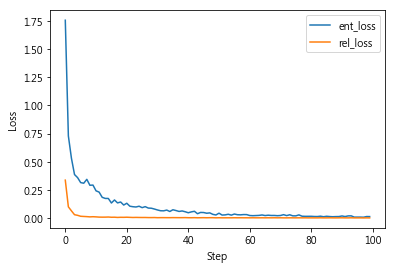

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(all_ent_loss[:100], label='ent_loss')
plt.plot(all_rel_loss[:100], label='rel_loss')
plt.xlabel("Step")
plt.ylabel("Loss") 
plt.legend()
plt.show()

In [74]:
import random
def random_choose(input_var):
    r_choose = []
    for i in range(BATCH_SIZE):
        r_choose.append(random.randint(0,len(input_var)))
    return r_choose
        
def ent_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,ent_size).argmax(2)
    return output

def rel_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,MAX_LEN,rel_size).argmax(3)
    return output

In [13]:
# Check predictions after training
with torch.no_grad():
    r_choose = random_choose(input_var)
    model.eval()
    ent_output, rel_output = model(input_var[r_choose].cuda() if USE_CUDA else input_var)
    
    ent_loss = criterion_tag(ent_output.cpu(), ent_var[r_choose].view(BATCH_SIZE*MAX_LEN))
    ent_output = ent_argmax(ent_output)
    
    rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
    
#     print('predict :', ent_output[0])
#     print('true :', ent_var[r_choose[0]])
    print()
    print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
    print('true :', index2tag(ent_var[r_choose[0]], ix_to_ent_tag))
    print()
    print('===================================================')
    print()
    print()
    print('predict :', index2tag(ent_output[1], ix_to_ent_tag))
    print('true :', index2tag(ent_var[r_choose[1]], ix_to_ent_tag))
    
    print()
    print("Entity loss : %.4f" % ent_loss)
    print("Relation loss : %.4f" % rel_loss)


predict : ['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
true : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O

In [76]:
with torch.no_grad():
    r_choose = random_choose(input_dev)

    model.eval()
    ent_output, rel_output = model(input_dev[r_choose].cuda() if USE_CUDA else input_dev)
    
    batchsize = input_dev[r_choose].size(0)
    
    ent_loss = criterion_tag(ent_output.cpu(), ent_dev[r_choose].view(batchsize*MAX_LEN))
    ent_output = ent_argmax(ent_output, batchsize)
    
    rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(batchsize*MAX_LEN*MAX_LEN))
    
    print(r_choose[0])
    print()
    print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
    print()
    print('true :', index2tag(ent_dev[r_choose[0]], ix_to_ent_tag))
    print()

    print("Entity loss : %.4f" % ent_loss)
    print("Relation loss : %.4f" % rel_loss)

torch.Size([2, 100])
38

predict : ['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

true : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

In [57]:
from sklearn.metrics import precision_recall_fscore_support

# *****測多關係

def batch_decode(ent_output, rel_output, batch_index, word_lists, true_ent, true_rel):
    rel_lists = []
    true_rel_lists = []
    combine_outputs = []
    combine_trues = []
    
    #================
    
    
    for e,r,i,te,tr in zip(ent_output, rel_output, batch_index, true_ent, true_rel):
        
        # 單句decode關係
        true_r_list, appear_error = decode_rel(te, tr)   # true
        r_list, appear_error = decode_rel(e, r)          # predict
        
        # 出現error，跳過這句
        if appear_error:
            continue
            
        true_rel_lists.append(true_r_list)
        rel_lists.append(r_list)
        
        # 算句子長度
        len_of_list = len(word_lists[i])
        word_list = word_lists[i]
        
        true_ent = index2tag(te, ix_to_ent_tag)
        pridict_ent = index2tag(e, ix_to_ent_tag)
        
        print(word_list)
        print(true_ent[:len_of_list])
        print(true_r_list[:len_of_list])

        print()
        print('Predict output')
        print(pridict_ent[:len_of_list])
        print(r_list[:len_of_list])
        print()
        print("=====================================")
        
        # 重新組成跟input data同樣的形式
        for word in range(len_of_list):
            # ========predict======================
            add_r = ''
            if type(r_list[word]) is list: 
                for single_r in r_list[word]:
                    add_r = add_r+single_r+' '
            combine_outputs.append(word_list[word]+' '+pridict_ent[word]+' '+add_r)
            
            # ==================true===================
            add_r = ''
            if type(true_r_list[word]) is list:     
                for single_r in true_r_list[word]:
                    try :
                        add_r = add_r+single_r+' '
                    except TypeError:
                        add_r = add_r+' '
                    
            combine_trues.append(word_list[word]+' '+true_ent[word]+' '+add_r)
                  
            
        combine_outputs.append(" ")
        combine_trues.append(" ")
      
    
    # 過濾 O tag的 index
    f_ix = filter_otag(combine_trues)
    
    filter_true = list(combine_trues[i] for i in f_ix)
    filter_output = list(combine_outputs[i] for i in f_ix)

#     print(np.array(filter_output))
#     print(np.array(filter_true))
    print()
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(filter_true, filter_output, average='micro', \
                                          labels=np.unique(filter_output)))        
    
    return filter_true, filter_output
    

    
def create_rel_info(ent_output):
    r_list = []     # 存放完整關係
    r_dict = {}     # 記錄關係資訊
    appear_error = False
    pred_ent = index2tag(ent_output, ix_to_ent_tag)

    e_loc = 0       # 當前遇到的entity的位置
    for loc, e in enumerate(pred_ent):
        if e[0]=='B':
            e_loc = loc
            r_dict[loc] = {
                '_2ndtag':e[2:],
                'end':loc,
            }
            r_list.append([])
                   
        elif e[0]=='I':
            
            # 錯誤來自於，entity預測錯誤，沒有預測到B tag，直接跳到I tag
            # 所以沒有紀錄e_loc
            try: 
                r_dict[e_loc]['end'] = loc
            except KeyError:
                appear_error = True
                break
                
            r_list.append([])
            
        else:
            r_list.append("")
              
    return r_list, r_dict, appear_error



def decode_rel(ent_output, rel_output):

    r_list, r_dict, appear_error = create_rel_info(ent_output)
    
    
    IsB = False           # 是否遇到B tag的lock
    IsNext = False        # 是否為B tag後面的tag 的lock
    num_reocrd = -1       # 紀錄pair數
    now_loc = 0
    end_loc = 0
    rel_keyerror = False
    
    for now in range(len(rel_output)):
        for loc, rel in enumerate(rel_output[now][:now+1]):
            rel = rel.cpu().numpy()
            
            # 有關係存在，且為B tag 
            if rel!=rel_tag_to_ix[REL_NONE] and IsB==False and IsNext==False:

                IsB = True
                IsNext = True
                tag = ix_to_rel_tag[int(rel)]
                num_reocrd+=1
                now_loc = loc
                
                # 錯誤來自於，now_loc找不到，也就是說，rel預測出來是有關係存在
                # 但預測是'O'
                # 而在entity中卻沒有預測出來，所以r_dict中沒有紀錄
                try:
                    end_loc = r_dict[now_loc]['end']
                except KeyError:
                    rel_keyerror = True
                    break
                
                
                second_tag = r_dict[now_loc]['_2ndtag']
                # check_loc 之後有多關係出現時要更改
                preAorB = check_loc(second_tag)
                nowAorB = 'B' if preAorB=='A' else 'A'
                
                pre_complete_rel = tag+"-"+str(num_reocrd)+"-"+preAorB
                now_complete_rel = tag+"-"+str(num_reocrd)+"-"+nowAorB
                
                # 將以前的token填上關係
                for token in range(now_loc, end_loc+1):
                    
                    '''AttributeError: 'str' object has no attribute 'append'''
                    r_list[token].append(pre_complete_rel)
                
                # 當前token填上關係
                r_list[now].append(now_complete_rel)

            
            # B tag後面的tag
            elif rel!=rel_tag_to_ix[REL_NONE] and IsB:
                # 如果還在這個entity的範圍內
                if loc<=end_loc:
                    pass
                
                # 超出現在這個entity的範圍，改lock
                else:
                    IsB = False
            
            # B tag後面的tag的關係，依照前面的關係複製
            elif rel!=rel_tag_to_ix[REL_NONE] and IsNext:
                r_list[now] = r_list[now-1]
                
            else:
                IsB = False
        
        if rel_keyerror:
            rel_keyerror = False
            break
                
                
    return r_list, appear_error
                

# 是三元關係中的前者還是後者                
# 有多種關係資料後這段要改
def check_loc(second_tag):
    if second_tag in rule[0]:
        return 'A'
    elif second_tag in rule[2]:
        return 'B'
    
    
def filter_otag(combine_trues):
    ix2eval = []
    
    for i, token in enumerate(combine_trues):
        # error : string index out of range
        # 出現空白
        try :
            token[2]!='O'
        except IndexError:
            continue
        else:
            if token[2]!='O':
                ix2eval.append(i)
            
    return ix2eval

In [72]:
import warnings
warnings.filterwarnings('always') 

score_predict = []
score_true = []

with torch.no_grad():
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        batchsize = batch_x.size(0)
        
        ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN))
        ent_output = ent_argmax(ent_output, batchsize)
        
        rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
        rel_output = rel_argmax(rel_output, batchsize)
    
        print()    
        print("Entity loss : %.4f" % ent_loss)
        print("Relation loss : %.4f" % rel_loss)
        print()
        
        filter_true, filter_output = batch_decode(ent_output, rel_output, \
                                    batch_index, raw_input_dev, batch_ent, batch_rel)
        
        # total score
        score_predict.extend(filter_output)
        score_true.extend(filter_true)
        
        
        print()
        print('==========================')
        print('==========================')
        print()
    
    print()
    print("Total score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(score_true, score_predict, average='micro', \
                                          labels=np.unique(score_predict)))   


Entity loss : 0.0377
Relation loss : 0.0013

['適', '用', '族', '群', '為', '乾', '燥', '肌', '、', '缺', '水', '保', '濕', '、', '2', '5', '歲', '以', '上', '肌', '膚']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '']

['若', '乾', '性', '肌', '膚', '使', '用', '會', '保', '濕', '度', '不', '足']
['O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O']
['', [], [], [], [], '', '', '', [], [], [], '', '']

Predict output
['O', 'B-STAT', 'I-STAT', 'I-STAT

['補', '充', '說', '明', ',', '因', '為', '我', '本', '身', '肌', '膚', '屬', '於', '敏', '感', '性', '肌', '膚', ',', '用', '此', '款', '面', '膜', '不', '會', '過', '敏', '喔', '~', '~', '而', '且', '保', '濕', '效', '果', '很', '強', '喔', '~', '^', '^']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O'

['有', '些', '保', '濕', '面', '膜', '，', '我', '的', '敏', '感', '性', '膚', '質', '如', '果', '敷', '太', '久', '，', '就', '會', '開', '始', '發', '癢', '，', '這', '款', '一', '直', '敷', '到', '最', '後', '都', '很', '舒', '服', '呢']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', 

['增', '加', '肌', '膚', '彈', '性', '及', '含', '水', '量', '，', '提', '高', '保', '濕', '效', '果', '，', '防', '止', '肌', '膚', '乾', '燥', '，', '去', '除', '細', '小', '皺', '紋', '，']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '']

['以', '前', '我', '有', '敷', 

['極', '效', '肌', '因', '修', '護', '巨', '藻', '、', '齒', '缘', '墨', '角', '藻', '複', '合', '水', '解', '酵', '母', '提', '取', '物', '，', '浸', '透', '濕', '潤', '乾', '燥', '肌', '膚', '，', '增', '強', '防', '護', '屏', '障', '，', '協', '同', '蘆', '薈', '、', '山', '金', '車', '及', '光', '果', '甘', '草', '植', '萃', '精', '華', '，', '深', '度', '安', '撫', '同', '時', '舒', '緩', '肌', '膚', '的', '不', '適', '，', '拋', '開', '惱', '人', '的', '乾', '燥', '缺', '水', '不', '安', '讓', '肌', '膚', '穩', '定']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['本', '身', '是', '極', '乾', '的', '膚', '質', ',', '常', '需', '要', '加', '強', '保', '濕']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

['第', '三', '種', '方', '式', '是', '每', '週', '1', '-', '2', '次', '，', '夜', '間', '所', '有', '保', '養', '程', '序', '後', '，', '以', '厚', '敷', '來', '加', '強', '肌', '膚', '乾', '燥', '部', '位', '的', '照', '顧']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

In [60]:
test_data = root+'facial_r2.test'
input_test, ent_test, rel_test, raw_index_test, raw_input_test = dev_preprocess(test_data)
test_loader = dataload(input_test, ent_test, rel_test, raw_index_test)

In [73]:
with torch.no_grad():
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(test_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        batchsize = batch_x.size(0)
        
        ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(BATCH_SIZE*MAX_LEN))
        ent_output = ent_argmax(ent_output, batchsize)
        
        rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(BATCH_SIZE*MAX_LEN*MAX_LEN))
        rel_output = rel_argmax(rel_output, batchsize)
    
        print()
        
        print("Entity loss : %.4f" % ent_loss)
        print("Relation loss : %.4f" % rel_loss)
        print()
        
        batch_decode(ent_output, rel_output, batch_index, raw_input_test, \
                     batch_ent, batch_rel)
        print()
        print('==========================')
        print()


Entity loss : 0.0601
Relation loss : 0.0015

['再', '加', '上', '它', '的', '保', '濕', '效', '果', '很', '讓', '我', '滿', '意', ',', '我', '是', '乾', '性', '肌', '膚', ',', '用', '起', '來', '蠻', '夠', '保', '濕', '的', ',']
['O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', 

['所', '以', '對', '乾', '燥', '敏', '感', '型', '肌', '膚', '使', '用', '後', '的', '確', '感', '覺', '不', '會', '有', '負', '擔', '，', '兼', '具', '保', '養', '、', '底', '妝', '、', '防', '曬', '的', '功', '能', '，', '效', '果', '還', '滿', '自', '然', '，', '保', '濕', '感', '也', '滿', '持', '久', '的', '，', '但', 'T', '字', '卻', '還', '是', '會', '有', '點', '小', '小', '的', '油', '感', '，', '但', '整', '體', '來', '說', '，', '產', '品', '效', '果', '滿', '好', '的']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '',

['1', '個', '月', '使', '用', '下', '來', '，', '感', '覺', '對', '清', '除', '黑', '頭', '粉', '刺', '及', '使', '毛', '孔', '緊', '緻', '是', '有', '效', '果', '的', '，', '但', '如', '果', '是', '敏', '感', '肌', '的', '朋', '友', '還', '是', '會', '建', '議', '用', '在', 'T', '字', '部', '位', '或', '先', '做', '局', '部', '測', '試', '再', '做', '全', '臉', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

['很', '適', '合', '雷', '射', '後', '的', '照', '顧', ',', '或', '是', '敏', '感', '肌', '的', '保', '養']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

['香', '味', '清', '淡', '，', '使', '用', '起', '來', '很', '水', '潤', '，', '又', '不', '黏', '膩', '，', '比', '一', '般', '保', '濕', '化', '妝', '水', '保', '濕', '，', '卻', '又', '不', '會', '使', '皮', '膚', '出', '油', '，', '很', '好', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B

['這', '款', '主', '打', '美', '白', '，', '但', '是', '這', '款', '保', '溼', '對', '我', '這', '種', '乾', '性', '肌', '來', '說', '真', '的', '是', '不', '夠', '力']
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '']

['前', '陣', '子', '皮', '膚', '過', '敏', '結', '果', '留', '下', '痕', '跡', '剛', '好', '收', '到', '這', '組', '商', '品', '主', '打', '美', '白', '真', '是', '開', '心', '打', '開', '包', '裝', '首', '先', '就', '先', '加', '分', '了', '，', '封', '口', '處'

['產', '品', '有', '藥', '妝', '的', '味', '道', '個', '人', '不', '是', '很', '喜', '歡', '，', '因', '產', '品', '內', '含', '麴', '酸', '成', '分', '，', '使', '用', '更', '需', '注', '重', '防', '曬', '之', '措', '施', '，', '敏', '感', '性', '肌', '膚', '於', '耳', '後', '試', '用', '後', '無', '過', '敏', '反', '應', '後', '方', '可', '使', '用', '，', '至', '於', '美', '白', '效', '果', '我', '想', '很', '難', '立', '竿', '見', '影', '需', '再', '觀', '察', '，', '但', '兩', '頰', '的', '曬', '斑', '似', '乎', '有', '停', '止', '加', '深', '之', '跡', '象']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', 

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f3212f93b70>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/usr/local/lib/python3.5/dist-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File 

AttributeError: 'str' object has no attribute 'append'